# Attention Scoring Functions



In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

Dot Product Attention
Masked Softmax Operation

In [2]:
def masked_softmax(X, valid_lens):  
    """Perform softmax operation by masking elements on the last axis."""
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

Illustrate how this function works

In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5773, 0.4227, 0.0000, 0.0000],
         [0.5674, 0.4326, 0.0000, 0.0000]],

        [[0.5241, 0.2477, 0.2282, 0.0000],
         [0.3224, 0.2454, 0.4322, 0.0000]]])

In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4743, 0.3170, 0.2087, 0.0000]],

        [[0.4712, 0.5288, 0.0000, 0.0000],
         [0.2280, 0.2086, 0.2058, 0.3576]]])

In [5]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

Scaled Dot-Product Attention

In [6]:
class DotProductAttention(nn.Module):  
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

Illustrate how the `DotProductAttention` class works

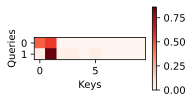

In [8]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

Additive Attention

In [9]:
class AdditiveAttention(nn.Module):  
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

See how `AdditiveAttention` works

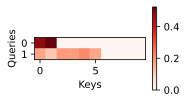

In [11]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')